In [570]:

import numpy as np
import math
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import jpholiday
import pickle
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
from matplotlib.lines import Line2D
from statsmodels.tsa.seasonal import STL
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
import warnings
warnings.filterwarnings('ignore')


# pandasの表示を設定
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50

In [571]:
train = pd.read_csv('train.csv', encoding='utf-8')
search_specified = pd.read_csv('search_specified.csv', encoding='utf-8')
search_unspecified = pd.read_csv('search_unspecified.csv', encoding='utf-8')
road = pd.read_csv('road_local.csv', encoding='utf-8')

### テーブルのマージと特徴量の追加

In [572]:
# day_of_week, day_of_year, holiday, tomorrow_holiday, yesterday_holidayを追加
def is_holiday(date):
    
    return (date.weekday() >= 5) or jpholiday.is_holiday(date)


def set_flags(df):
    
    df['tomorrow'] = df['date'] + pd.to_timedelta(1, 'd')
    #df['yesterday'] = df['date'] - pd.to_timedelta(1, 'd')
    df['day_of_week'] = df['date'].dt.weekday
    
    holidays = df['date'].apply(jpholiday.is_holiday)

    df['holiday'] = ((df['day_of_week'] >= 5) | holidays).astype(int)
    df['tomorrow_holiday'] = ((df['tomorrow'].dt.weekday >= 5) | holidays.shift(-1)).astype(int)
    #df['yesterday_holiday'] = ((df['yesterday'].dt.weekday >= 5) | holidays.shift(1)).astype(int)
    
    df = df.drop(['tomorrow'], axis=1)
    
    return df

search_unspecified['date'] = pd.to_datetime(search_unspecified['date'])

search_unspecified = set_flags(search_unspecified)

search_unspecified['day_of_year'] = search_unspecified['date'].dt.dayofyear

In [573]:
# datetime, dateをyear, month, day, hourに展開
# テーブルをマージ
# 不要なカラムを削除
def expand_datetime(df):
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
    if 'datetime' in df.columns:
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
    return df

train['datetime'] = pd.to_datetime(train['datetime'])
train['date'] = train['datetime'].dt.date
train['date'] = pd.to_datetime(train['date'])
search_specified['datetime'] = pd.to_datetime(search_specified['datetime'])
search_unspecified['date'] = pd.to_datetime(search_unspecified['date'])

train = expand_datetime(train)

train_merged = train.merge(search_specified, on=['datetime', 'start_code', 'end_code'], how='left')

train_merged = train_merged.merge(search_unspecified, on=['date', 'start_code', 'end_code'], how='left')

train_merged = train_merged.merge(road.drop(['start_name', 'end_name', 'start_KP', 'end_KP', 'start_pref_code', 'end_pref_code', 'start_lat', 'end_lat', 'start_lng', 'end_lng', 'start_degree', 'end_degree', 'direction', 'road_code'], axis=1), on=['start_code', 'end_code'], how='left')

In [574]:
# month, day, hour, day_of_weekをsin, cos変換

def sin_cos_encoder(data, cols):

    for col in cols:
        data[f'{col}_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[f'{col}_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())

    return data


train_merged = sin_cos_encoder(train_merged, ['hour','day_of_year'])

In [575]:
# 連休何日目か(n_of_holidays)
mask = train_merged['holiday'] != train_merged['holiday'].shift(1).fillna(0)
train_merged['n_of_holidays'] = train_merged.groupby(mask.cumsum()).cumcount() + 1
train_merged.loc[train_merged['holiday'] == 0, 'n_of_holidays'] = 0
#train_merged['holiday_term_len'] = train_merged.groupby(mask.cumsum())['holiday'].transform(sum)
#train_merged.loc[train_merged['holiday'] == 0, 'holiday_term_len'] = 0

In [576]:
# section(始点IC-KP-終点IC)を追加しラベルエンコード
train_merged['section'] = train_merged['start_code'].astype(str) + '_' + train_merged['KP'].astype(str) + '_' + train_merged['end_code'].astype(str)

label_encoder = LabelEncoder()
train_merged['section'] = label_encoder.fit_transform(train_merged['section'])

with open('label.pickle', 'wb') as le:
    pickle.dump(label_encoder, le)

In [577]:
## 「この区間の時刻平均速度」と「前の区間の同時刻平均速度」の変動率(speed_change_behind_mean)、
## 「この区間の時刻平均速度」と「次の区間の同時刻平均速度」の変動率(speed_change_forward_mean)を追加
#
#section_speed_mean = train_merged.groupby(['hour', 'section']).agg(mean_speed_section=('speed', 'mean')).reset_index()
#start_speed_mean = train_merged.groupby(['hour', 'start_code']).agg(mean_speed_start=('speed', 'mean')).reset_index()
#end_speed_mean = train_merged.groupby(['hour', 'end_code']).agg(mean_speed_end=('speed', 'mean')).reset_index()
#
#base = train_merged[['start_code', 'end_code', 'section', 'hour']]
#
#section_speed_mean = section_speed_mean.merge(base, on=['hour', 'section'], how='left')
#start_speed_mean = start_speed_mean.merge(base, on=['hour', 'start_code'], how='left')
#end_speed_mean = end_speed_mean.merge(base, on=['hour', 'end_code'], how='left')
#
#for section in tqdm(train_merged['section'].unique()):
#    mean_speeds_section = section_speed_mean[section_speed_mean['section'] == section]['mean_speed_section'].reset_index(drop=True)
#    mean_speeds_end = end_speed_mean[end_speed_mean['section'] == section]['mean_speed_end'].reset_index(drop=True)
#    train_merged.loc[train_merged['section'] == section, 'speed_change_behind_mean'] = ((mean_speeds_section - mean_speeds_end) / mean_speeds_end).set_axis(train_merged.loc[train_merged['section'] == section].index)
#    
#for section in tqdm(train_merged['section'].unique()):
#    mean_speeds_section = section_speed_mean[section_speed_mean['section'] == section]['mean_speed_section'].reset_index(drop=True)
#    mean_speeds_start = start_speed_mean[start_speed_mean['section'] == section]['mean_speed_start'].reset_index(drop=True)
#    train_merged.loc[train_merged['section'] == section, 'speed_change_forward_mean'] = ((mean_speeds_section - mean_speeds_start) / mean_speeds_start).set_axis(train_merged.loc[train_merged['section'] == section].index)

In [578]:
#section_congestion_mean = train_merged.groupby(['hour', 'section']).agg(mean_congestion_section=('is_congestion', 'mean')).reset_index()
#start_congestion_mean = train_merged.groupby(['hour', 'start_code']).agg(mean_congestion_start=('is_congestion', 'mean')).reset_index()
#end_congestion_mean = train_merged.groupby(['hour', 'end_code']).agg(mean_congestion_end=('is_congestion', 'mean')).reset_index()
#
#base = train_merged[['start_code', 'end_code', 'section', 'hour']]
#
#section_congestion_mean = section_congestion_mean.merge(base, on=['hour', 'section'], how='left')
#start_congestion_mean = start_congestion_mean.merge(base, on=['hour', 'start_code'], how='left')
#end_congestion_mean = end_congestion_mean.merge(base, on=['hour', 'end_code'], how='left')
#
#for section in tqdm(train_merged['section'].unique()):
#    mean_congestions_section = section_congestion_mean[section_congestion_mean['section'] == section]['mean_congestion_section'].reset_index(drop=True)
#    mean_congestions_end = end_congestion_mean[end_congestion_mean['section'] == section]['mean_congestion_end'].reset_index(drop=True)
#    train_merged.loc[train_merged['section'] == section, 'congestion_behind_mean'] = mean_congestions_end.set_axis(train_merged.loc[train_merged['section'] == section].index)
#    
#for section in tqdm(train_merged['section'].unique()):
#    mean_congestions_section = section_congestion_mean[section_congestion_mean['section'] == section]['mean_congestion_section'].reset_index(drop=True)
#    mean_congestions_start = start_congestion_mean[start_congestion_mean['section'] == section]['mean_congestion_start'].reset_index(drop=True)
#    train_merged.loc[train_merged['section'] == section, 'congestion_forward_mean'] = mean_congestions_start.set_axis(train_merged.loc[train_merged['section'] == section].index)


In [579]:
# 同区間同時刻のis_congestionのカウント数
count = train_merged.groupby(['hour', 'section'])['is_congestion'].sum().reset_index().rename(columns={'is_congestion':'congestion_count'})
train_merged = train_merged.merge(count, on=['hour', 'section'], how='left')

# 同区間1時間前のis_congestionのカウント数
one_hour_before = train_merged['datetime'] + pd.Timedelta(hours=1)
count_one_hour_before = train_merged.groupby(['section', one_hour_before.dt.hour])['is_congestion'].sum().reset_index()
count_one_hour_before = count_one_hour_before.rename(columns={'is_congestion': 'congestion_count_one_hour_before', 'datetime': 'hour'})
train_merged = train_merged.merge(count_one_hour_before, on=['section', 'hour'], how='left')
    
## 同区間1時間後のis_congestionのカウント数
#one_hour_after = train_merged['datetime'] - pd.Timedelta(hours=1)
#count_one_hour_after = train_merged.groupby(['section', one_hour_after.dt.hour])['is_congestion'].sum().reset_index()
#count_one_hour_after = count_one_hour_after.rename(columns={'is_congestion': 'congestion_count_one_hour_after', 'datetime': 'hour'})
#train_merged = train_merged.merge(count_one_hour_after, on=['section', 'hour'], how='left')

In [580]:
# OCCのnanは平均値埋め
train_merged.loc[train_merged['OCC'].isnull(), 'OCC'] = train_merged['OCC'].mean()

In [581]:
# 「この区間の現時刻のOCC」の「この区間の一日の平均OCC」に対する変動率(OCC_change_self_mean)を追加
#section_OCC_mean = train_merged.groupby(['date', 'section'])['OCC'].mean().reset_index().rename(columns={'OCC':'mean_OCC'})
#
#for section in tqdm(train_merged['section'].unique()):
#    section_rows = train_merged[train_merged['section'] == section][['date', 'datetime', 'OCC', 'section']].reset_index(drop=True)
#    mean_OCCs = section_rows.merge(section_OCC_mean, on=['date', 'section'], how='left')['mean_OCC'].reset_index(drop=True)
#    train_merged.loc[train_merged['section'] == section, 'OCC_change_self_mean'] = ((section_rows['OCC'] - mean_OCCs) / mean_OCCs).set_axis(train_merged.loc[train_merged['section'] == section].index)
#    
#train_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
#train_merged['OCC_change_self_mean'].fillna(train_merged['OCC_change_self_mean'].mean(), inplace=True)

In [582]:
## OCCの平均(OCC_hour_mean)を追加
#hour_OCC_mean = train_merged.groupby(['hour', 'section'])['OCC'].mean().reset_index().rename(columns={'OCC':'mean_OCC'})
#
#for section in tqdm(train_merged['section'].unique()):
#    section_rows = train_merged[train_merged['section'] == section][['hour', 'section']].reset_index(drop=True)
#    mean_OCCs = section_rows.merge(hour_OCC_mean, on=['hour', 'section'], how='left')['mean_OCC'].reset_index(drop=True)
#    train_merged.loc[train_merged['section'] == section, 'OCC_hour_mean'] = mean_OCCs.set_axis(train_merged.loc[train_merged['section'] == section].index)

In [583]:
## OCCのラグ特徴量(144期前からの変化率)を追加
## 欠損値は平均値で埋める
#OCC_t_minus144 = train_merged.groupby('section')['OCC'].shift(144)
#
#train_merged['OCC_change_-144'] = (train_merged['OCC'] - OCC_t_minus144) / OCC_t_minus144
#
#train_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
#
#train_merged['OCC_change_-144'].fillna(train_merged['OCC_change_-144'].mean(), inplace=True)


In [584]:
## 「この区間の現時刻の速度」の「この区間の一日の平均速度」に対する変動率(speed_change_self_mean)を追加
#section_speed_mean = train_merged.groupby(['date', 'section'])['speed'].mean().reset_index().rename(columns={'speed':'mean_speed'})
#
#for section in tqdm(train_merged['section'].unique()):
#    section_rows = train_merged[train_merged['section'] == section][['date', 'datetime', 'speed', 'section']].reset_index(drop=True)
#    mean_speeds = section_rows.merge(section_speed_mean, on=['date', 'section'], how='left')['mean_speed'].reset_index(drop=True)
#    train_merged.loc[train_merged['section'] == section, 'speed_change_self_mean'] = ((section_rows['speed'] - mean_speeds) / mean_speeds).set_axis(train_merged.loc[train_merged['section'] == section].index)

In [585]:
##「この区間の現時刻の速度」の「全区間の一日の平均速度」に対する変動率(speed_change_all_mean)を追加
#all_speed_mean = train_merged.groupby(['date'])['speed'].mean().reset_index().rename(columns={'speed':'mean_speed'})
#
#for section in tqdm(train_merged['section'].unique()):
#    section_rows = train_merged[train_merged['section'] == section][['date', 'datetime', 'speed', 'section']].reset_index(drop=True)
#    mean_speeds = section_rows.merge(all_speed_mean, on=['date'], how='left')['mean_speed'].reset_index(drop=True)
#    train_merged.loc[train_merged['section'] == section, 'speed_change_all_mean'] = ((section_rows['speed'] - mean_speeds) / mean_speeds).set_axis(train_merged.loc[train_merged['section'] == section].index)

In [586]:
## speedの同時刻同区間平均(speed_hour_mean)を追加
#hour_speed_mean = train_merged.groupby(['hour', 'section'])['speed'].mean().reset_index().rename(columns={'speed':'mean_speed'})
#
#for section in tqdm(train_merged['section'].unique()):
#    section_rows = train_merged[train_merged['section'] == section][['hour', 'section']].reset_index(drop=True)
#    mean_speeds = section_rows.merge(hour_speed_mean, on=['hour', 'section'], how='left')['mean_speed'].reset_index(drop=True)
#    train_merged.loc[train_merged['section'] == section, 'speed_hour_mean'] = mean_speeds.set_axis(train_merged.loc[train_merged['section'] == section].index)


In [587]:
## speedのラグ特徴量(過去24期の平均、24,48,72,96,120,144,168期前からの変化率)を追加
##speed_t_minus1 = train_merged.groupby('section')['speed'].shift(1)
##speed_t_minus2 = train_merged.groupby('section')['speed'].shift(2)
#speed_t_minus24 = train_merged.groupby('section')['speed'].shift(24)
#speed_t_minus48 = train_merged.groupby('section')['speed'].shift(48)
#speed_t_minus72 = train_merged.groupby('section')['speed'].shift(72)
#speed_t_minus96 = train_merged.groupby('section')['speed'].shift(96)
#speed_t_minus120 = train_merged.groupby('section')['speed'].shift(120)
#speed_t_minus144 = train_merged.groupby('section')['speed'].shift(144)
#
#train_merged['speed_t_t-23_mean'] = train_merged.groupby('section')['speed'].rolling(24, min_periods=1).mean().reset_index(level=0, drop=True)
#
##train_merged['speed_change_-1'] = (train_merged['speed'] - speed_t_minus1) / speed_t_minus1
##train_merged['speed_change_-2'] = (train_merged['speed'] - speed_t_minus2) / speed_t_minus2
#train_merged['speed_change_-24'] = (train_merged['speed'] - speed_t_minus24) / speed_t_minus24
#train_merged['speed_change_-48'] = (train_merged['speed'] - speed_t_minus48) / speed_t_minus48
#train_merged['speed_change_-72'] = (train_merged['speed'] - speed_t_minus72) / speed_t_minus72
#train_merged['speed_change_-96'] = (train_merged['speed'] - speed_t_minus96) / speed_t_minus96
#train_merged['speed_change_-120'] = (train_merged['speed'] - speed_t_minus120) / speed_t_minus120
#train_merged['speed_change_-144'] = (train_merged['speed'] - speed_t_minus144) / speed_t_minus144
#
## 欠損値を平均値で埋める
#train_merged['speed_t_t-23_mean'].fillna(train_merged['speed_t_t-23_mean'].mean(), inplace=True)
##train_merged['speed_change_-1'].fillna(train_merged['speed_change_-1'].mean(), inplace=True)
##train_merged['speed_change_-2'].fillna(train_merged['speed_change_-2'].mean(), inplace=True)
#train_merged['speed_change_-24'].fillna(train_merged['speed_change_-24'].mean(), inplace=True)
#train_merged['speed_change_-48'].fillna(train_merged['speed_change_-48'].mean(), inplace=True)
#train_merged['speed_change_-72'].fillna(train_merged['speed_change_-72'].mean(), inplace=True)
#train_merged['speed_change_-96'].fillna(train_merged['speed_change_-96'].mean(), inplace=True)
#train_merged['speed_change_-120'].fillna(train_merged['speed_change_-120'].mean(), inplace=True)
#train_merged['speed_change_-144'].fillna(train_merged['speed_change_-144'].mean(), inplace=True)
#

In [588]:
# allCarsの同時刻同区間平均(allCars_hour_mean)を追加
train_merged['allCars_hour_mean'] = train_merged.groupby(['hour', 'section'])['allCars'].transform('mean')

# 同区間1時間前のallCarsの平均
one_hour_before = train_merged['datetime'] + pd.Timedelta(hours=1)
mean_one_hour_before = train_merged.groupby(['section', one_hour_before.dt.hour])['allCars'].mean().reset_index()
mean_one_hour_before = mean_one_hour_before.rename(columns={'allCars': 'allCars_mean_one_hour_before', 'datetime': 'hour'})
train_merged = train_merged.merge(mean_one_hour_before, on=['section', 'hour'], how='left')

In [589]:
#search_specified, search_unspecified-24時間ずらす
train_merged['search_specified'] = train_merged.groupby('section')['search_specified'].shift(-24)
train_merged['search_unspecified'] = train_merged.groupby('section')['search_unspecified'].shift(-24)


In [590]:
# search_specifiedの同時刻同区間平均(search_specified_hour_mean)を追加
train_merged['search_specified_hour_mean'] = train_merged.groupby(['hour', 'section'])['search_specified'].transform('mean')
    
train_merged['search_specified'].fillna(train_merged['search_specified_hour_mean'], inplace=True)

In [591]:
# search_unspecifiedの同区間平均(search_unspecified_mean)を追加
train_merged['search_unspecified_mean'] = train_merged.groupby('section')['search_unspecified'].transform('mean')
    
train_merged['search_unspecified'].fillna(train_merged['search_unspecified_mean'], inplace=True)

In [592]:
# 目的変数として翌日同時刻のis_congestion(is_congestion_tomorrow)を追加
train_merged['is_congestion_tomorrow'] = train_merged.groupby('section')['is_congestion'].shift(-24)
    
train_merged = train_merged.loc[train_merged['is_congestion_tomorrow'].notnull()]
    

In [593]:
# 分布が歪な説明変数は対数変換
#train_merged['OCC'] = np.log1p(train_merged['OCC'])
#train_merged['search_specified'] = np.log1p(train_merged['search_specified'])
#train_merged['search_unspecified'] = np.log1p(train_merged['search_unspecified'])
#train_merged['search_specified_hour_mean'] = np.log1p(train_merged['search_specified_hour_mean'])
#train_merged['search_unspecified_mean'] = np.log1p(train_merged['search_unspecified_mean'])

train_merged = train_merged.drop(['date', 'day_of_year', 'month', 'day', 'hour', 'limit_speed', 'holiday'], axis=1)

In [594]:
train_merged.columns

Index(['datetime', 'start_code', 'end_code', 'KP', 'OCC', 'allCars', 'speed',
       'is_congestion', 'year', 'search_specified', 'search_unspecified',
       'day_of_week', 'tomorrow_holiday', 'hour_sin', 'hour_cos',
       'day_of_year_sin', 'day_of_year_cos', 'n_of_holidays', 'section',
       'congestion_count', 'congestion_count_one_hour_before',
       'allCars_hour_mean', 'allCars_mean_one_hour_before',
       'search_specified_hour_mean', 'search_unspecified_mean',
       'is_congestion_tomorrow'],
      dtype='object')

In [595]:
train_merged_profile = ProfileReport(train_merged, title="Profiling Report:Train Merged", minimal=True)
train_merged_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [596]:
train_merged.to_csv('train_merged.csv', index=False)
train_merged = pd.read_csv('train_merged.csv', encoding='utf-8')

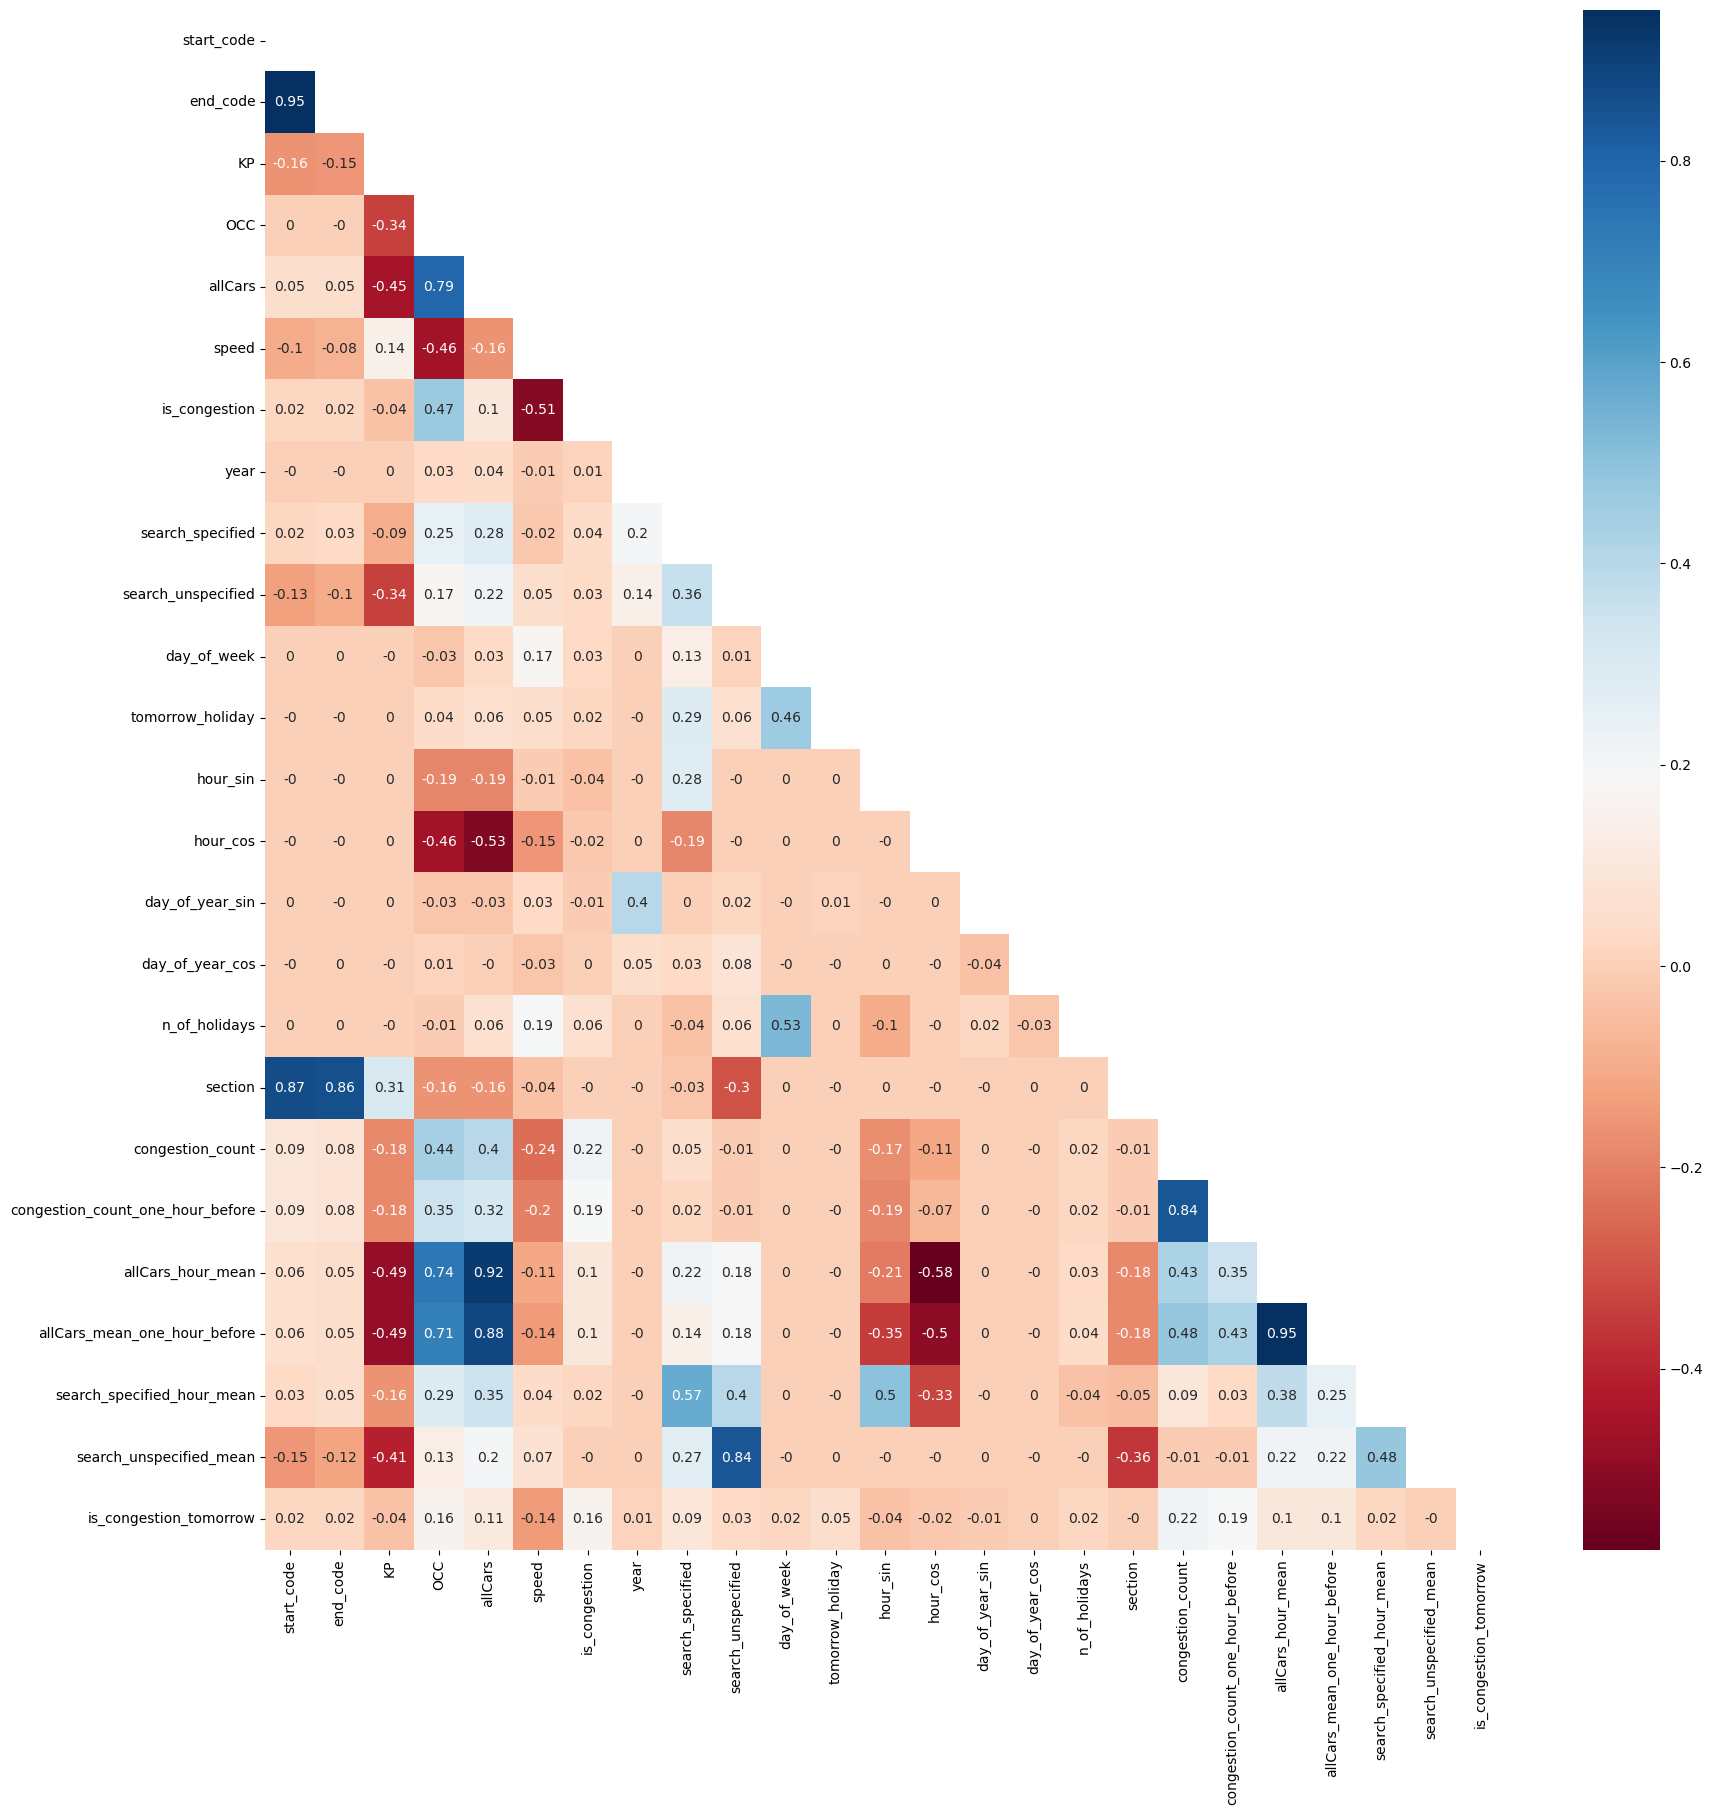

In [597]:
%matplotlib inline

corr_df = train_merged.corr().round(2)

mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask, k=0)] = True

plt.figure(figsize=(20,20))
ax = sns.heatmap(corr_df, cmap="RdBu", annot=True, mask=mask)

plt.show()